In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import warnings
import time
import gc
from tqdm import trange

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 0)
pd.set_option('display.max_columns', 0)

# Load Data and Preprocessing

## UNSW-NB15

In [2]:
# Load Data
train_raw = pd.read_csv('../Data/UNSW_NB15/train.csv')
print(train_raw.shape)
test_raw = pd.read_csv('../Data/UNSW_NB15/test.csv')
print(test_raw.shape)
# Seperate label and drop unnecessary features
train_X = train_raw.drop(['id', 'attack_cat', 'label'], axis=1).select_dtypes(include='number')
print(train_X.shape)
train_Y = train_raw['label']
test_X = test_raw.drop(['id', 'attack_cat', 'label'], axis=1).select_dtypes(include='number')
print(test_X.shape)
test_Y = test_raw['label']

(82332, 45)
(175341, 45)
(82332, 39)
(175341, 39)


## NSL-KDD

In [2]:
# Load Data
train_raw = pd.read_csv('../Data/NSL_KDD/train.csv')
print(train_raw.shape)
test_raw = pd.read_csv('../Data/NSL_KDD/test.csv')
print(test_raw.shape)

# Seperate label and Drop ID
def LabelEncode(x):
    if x == 'normal':
        return 0
    else:
        return 1
train_X = train_raw.drop(['class'], axis=1).select_dtypes(include='number')
print(train_X.shape)
train_Y = train_raw['class'].apply(LabelEncode)
print(train_Y.unique())
test_X = test_raw.drop(['class'], axis=1).select_dtypes(include='number')
print(test_X.shape)
test_Y = test_raw['class'].apply(LabelEncode)

(125973, 42)
(22544, 42)
(125973, 38)
[0 1]
(22544, 38)


## CICIDS-2017

In [ ]:
# Load Data
train_raw = pd.read_csv('../Data/CICIDS_2017/train.csv')
print(train_raw.shape)
test_raw = pd.read_csv('../Data/CICIDS_2017/test.csv')
print(test_raw.shape)

# Seperate label and Drop ID
def LabelEncode(x):
    if x == 'BENIGN':
        return 0
    else:
        return 1
train_X = train_raw.drop(['Label'], axis=1).select_dtypes(include='number')
print(train_X.shape)
train_Y = train_raw['Label'].apply(LabelEncode)

# Feature Selection

In [3]:
# Normalize data with min, max of training data
test_X1 = (test_X - train_X.min(axis=0)) / (train_X.max(axis=0) - train_X.min(axis=0))
train_X1 = (train_X - train_X.min(axis=0)) / (train_X.max(axis=0) - train_X.min(axis=0))

test_X1[test_X1 < 0] = 0
test_X1[test_X1 > 1] = 1

train_X1.fillna(0, inplace=True)
test_X1.fillna(0, inplace=True)

In [4]:
# correlation based feature selection
corr = train_X1.corr().abs()

correlation_threshold = 0.8
corr.values[np.tril_indices_from(corr.values)] = np.nan
redundant = []
for j in corr.columns:
    for i in corr.index:
        if corr.loc[i, j] > correlation_threshold:
            redundant.append((i, j))

train_corr = train_X1.copy()
train_corr['Label'] = train_Y
corr2 = train_corr.corr().abs()

corr3 = corr2['Label'].iloc[:-1].copy()
drop = []

# drop features having lower correlation with label
for i, j in redundant:
    if corr3[i] > corr3[j]:
        if j not in drop:
            drop.append(j)
    elif i not in drop:
        drop.append(i)
print(drop)

del corr, train_corr, corr2, corr3
gc.collect()

train_X1 = train_X1.drop(drop, axis=1)
print(train_X1.shape)
test_X1 = test_X1.drop(drop, axis=1)
print(test_X1.shape)

['num_compromised', 'hot', 'srv_serror_rate', 'rerror_rate', 'dst_host_same_srv_rate', 'serror_rate', 'dst_host_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']
(125973, 29)
(22544, 29)


In [5]:
from sklearn.feature_selection import SelectKBest, SelectFromModel, SequentialFeatureSelector, chi2, f_classif, mutual_info_classif
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearnex import patch_sklearn, unpatch_sklearn

patch_sklearn()
kf = StratifiedKFold(shuffle=True, random_state=0)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [6]:
dataset_name = 'NSL_KDD'
methods = ['chi2', 'ANOVA', 'mutualinfo', 'sfs(gb)', 'sfs(lr)', 'im(gb)', 'im(lr)']
colors = ['blue', 'red', 'black', 'cyan', 'darkcyan', 'green', 'darkgreen']
subset_all = []
n_of_features = train_X1.shape[1]

In [7]:
# select 1 best feature iteratively with chi2, ANOVA, mutual info

for sf in [chi2, f_classif, mutual_info_classif]:
    selector = SelectKBest(sf, k='all')
    selector.fit(train_X1, train_Y)
    sorted_index = np.argsort(-selector.scores_)
    subset_all.append(train_X1.columns[sorted_index])
    print(train_X1.columns[sorted_index])

Index(['dst_host_srv_serror_rate', 'logged_in', 'dst_host_srv_count',
       'same_srv_rate', 'count', 'srv_rerror_rate', 'dst_host_count',
       'dst_host_diff_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
       'wrong_fragment', 'dst_host_same_src_port_rate', 'is_guest_login',
       'dst_host_srv_diff_host_rate', 'duration', 'su_attempted', 'root_shell',
       'num_access_files', 'num_file_creations', 'num_shells', 'land',
       'num_root', 'src_bytes', 'dst_bytes', 'is_host_login', 'urgent',
       'num_failed_logins', 'srv_count', 'num_outbound_cmds'],
      dtype='object')
Index(['same_srv_rate', 'dst_host_srv_count', 'logged_in',
       'dst_host_srv_serror_rate', 'count', 'dst_host_count',
       'srv_rerror_rate', 'dst_host_diff_srv_rate', 'diff_srv_rate',
       'srv_diff_host_rate', 'wrong_fragment', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'duration', 'is_guest_login',
       'num_access_files', 'su_attempted', 'num_file_creations', 'root

In [8]:
# select 1 best feature iteratively with SFS, using RF, LR
for model in [GradientBoostingClassifier(random_state=0), RidgeClassifier(random_state=0)]:
    cols = []
    selector = SequentialFeatureSelector(model, n_features_to_select=1, scoring='f1', cv=kf, n_jobs=-1)
    for k in trange(n_of_features-1):
        train_X2 = train_X1.drop(cols, axis=1)
        selector.fit(train_X2, train_Y)
        f = train_X2.columns[selector.get_support()]
        cols.append(f[0])
    cols.append(train_X1.columns.drop(cols)[0])
    subset_all.append(cols)
    print(cols)

100%|██████████| 28/28 [13:25<00:00, 28.78s/it]


['diff_srv_rate', 'same_srv_rate', 'dst_host_srv_count', 'logged_in', 'dst_host_diff_srv_rate', 'count', 'dst_host_srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_serror_rate', 'dst_host_same_src_port_rate', 'srv_diff_host_rate', 'srv_count', 'srv_rerror_rate', 'wrong_fragment', 'src_bytes', 'duration', 'num_failed_logins', 'land', 'dst_bytes', 'num_root', 'num_file_creations', 'num_shells', 'urgent', 'root_shell', 'su_attempted', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login']


100%|██████████| 28/28 [00:27<00:00,  1.01it/s]

['dst_host_srv_count', 'logged_in', 'same_srv_rate', 'count', 'dst_host_srv_serror_rate', 'dst_host_count', 'srv_rerror_rate', 'dst_host_same_src_port_rate', 'dst_host_diff_srv_rate', 'diff_srv_rate', 'dst_host_srv_diff_host_rate', 'wrong_fragment', 'duration', 'land', 'src_bytes', 'dst_bytes', 'urgent', 'num_failed_logins', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'srv_count', 'srv_diff_host_rate']


In [9]:
# select 1 best feature iteratively with importance, using RF, LR
for model in [GradientBoostingClassifier(random_state=0), RidgeClassifier(random_state=0)]:
    cols = []
    selector = SelectFromModel(model, threshold=-np.inf, max_features=1)
    for k in trange(n_of_features-1):
        train_X2 = train_X1.drop(cols, axis=1)
        selector.fit(train_X2, train_Y)
        f = train_X2.columns[selector.get_support()]
        cols.append(f[0])
    cols.append(train_X1.columns.drop(cols)[0])
    subset_all.append(cols)
    print(cols)

100%|██████████| 28/28 [02:32<00:00,  5.44s/it]


['same_srv_rate', 'diff_srv_rate', 'dst_host_srv_count', 'logged_in', 'dst_host_diff_srv_rate', 'count', 'dst_host_srv_serror_rate', 'dst_host_count', 'dst_host_srv_diff_host_rate', 'dst_host_same_src_port_rate', 'srv_count', 'srv_diff_host_rate', 'srv_rerror_rate', 'duration', 'dst_bytes', 'src_bytes', 'wrong_fragment', 'num_root', 'num_access_files', 'is_guest_login', 'num_file_creations', 'su_attempted', 'root_shell', 'num_shells', 'num_failed_logins', 'land', 'urgent', 'is_host_login', 'num_outbound_cmds']


100%|██████████| 28/28 [00:01<00:00, 22.33it/s]

['wrong_fragment', 'dst_host_srv_diff_host_rate', 'src_bytes', 'dst_host_srv_serror_rate', 'same_srv_rate', 'count', 'num_failed_logins', 'num_file_creations', 'dst_host_srv_count', 'logged_in', 'num_access_files', 'duration', 'dst_host_count', 'num_shells', 'land', 'su_attempted', 'num_root', 'srv_rerror_rate', 'dst_host_diff_srv_rate', 'diff_srv_rate', 'root_shell', 'srv_diff_host_rate', 'dst_bytes', 'urgent', 'is_host_login', 'is_guest_login', 'dst_host_same_src_port_rate', 'srv_count', 'num_outbound_cmds']


In [10]:
# save selected feature sets to csv file
pd.DataFrame(subset_all, index=methods).to_csv('../Results/' + dataset_name + '/Individual_features.csv')

# Cross Validation and Test

## Linear Regression

In [11]:
# measure performance by cv(f1 score) and test(f1 score)
cv_time_all_LR = []
cv_f1_all_LR = []
test_time_all_LR = []
test_f1_all_LR = []
model = RidgeClassifier(alpha=0.01, random_state=0)
for i in range(len(subset_all)):
    cv_time = []
    cv_f1 = []
    test_time = []
    test_f1 = []
    for k in trange(n_of_features):
        # cross validation
        second = time.time()
        cv = cross_val_score(model, train_X1[subset_all[i][:k+1]], train_Y, scoring='f1', cv=kf, n_jobs=-1)
        second2 = time.time()
        cv_time.append(second2 - second)
        cv_f1.append((cv.mean(), cv.std()))

        model.fit(train_X1[subset_all[i][:k+1]], train_Y)
        second = time.time()
        predict = model.predict(test_X1[subset_all[i][:k+1]])
        score = f1_score(test_Y, predict)
        second2 = time.time()
        test_time.append(second2 - second)
        test_f1.append(score)
    
    cv_time_all_LR.append(cv_time)
    cv_f1_all_LR.append(cv_f1)
    test_time_all_LR.append(test_time)
    test_f1_all_LR.append(test_f1)

100%|██████████| 29/29 [00:11<00:00,  2.58it/s]


In [12]:
pd.DataFrame(cv_time_all_LR, index=methods).to_csv('../Results/' + dataset_name + '/Individual_CV_Time_LR.csv')
pd.DataFrame(cv_f1_all_LR, index=methods).to_csv('../Results/' + dataset_name + '/Individual_CV_F1_LR.csv')
pd.DataFrame(test_time_all_LR, index=methods).to_csv('../Results/' + dataset_name + '/Individual_Test_Time_LR.csv')
pd.DataFrame(test_f1_all_LR, index=methods).to_csv('../Results/' + dataset_name + '/Individual_Test_F1_LR.csv')

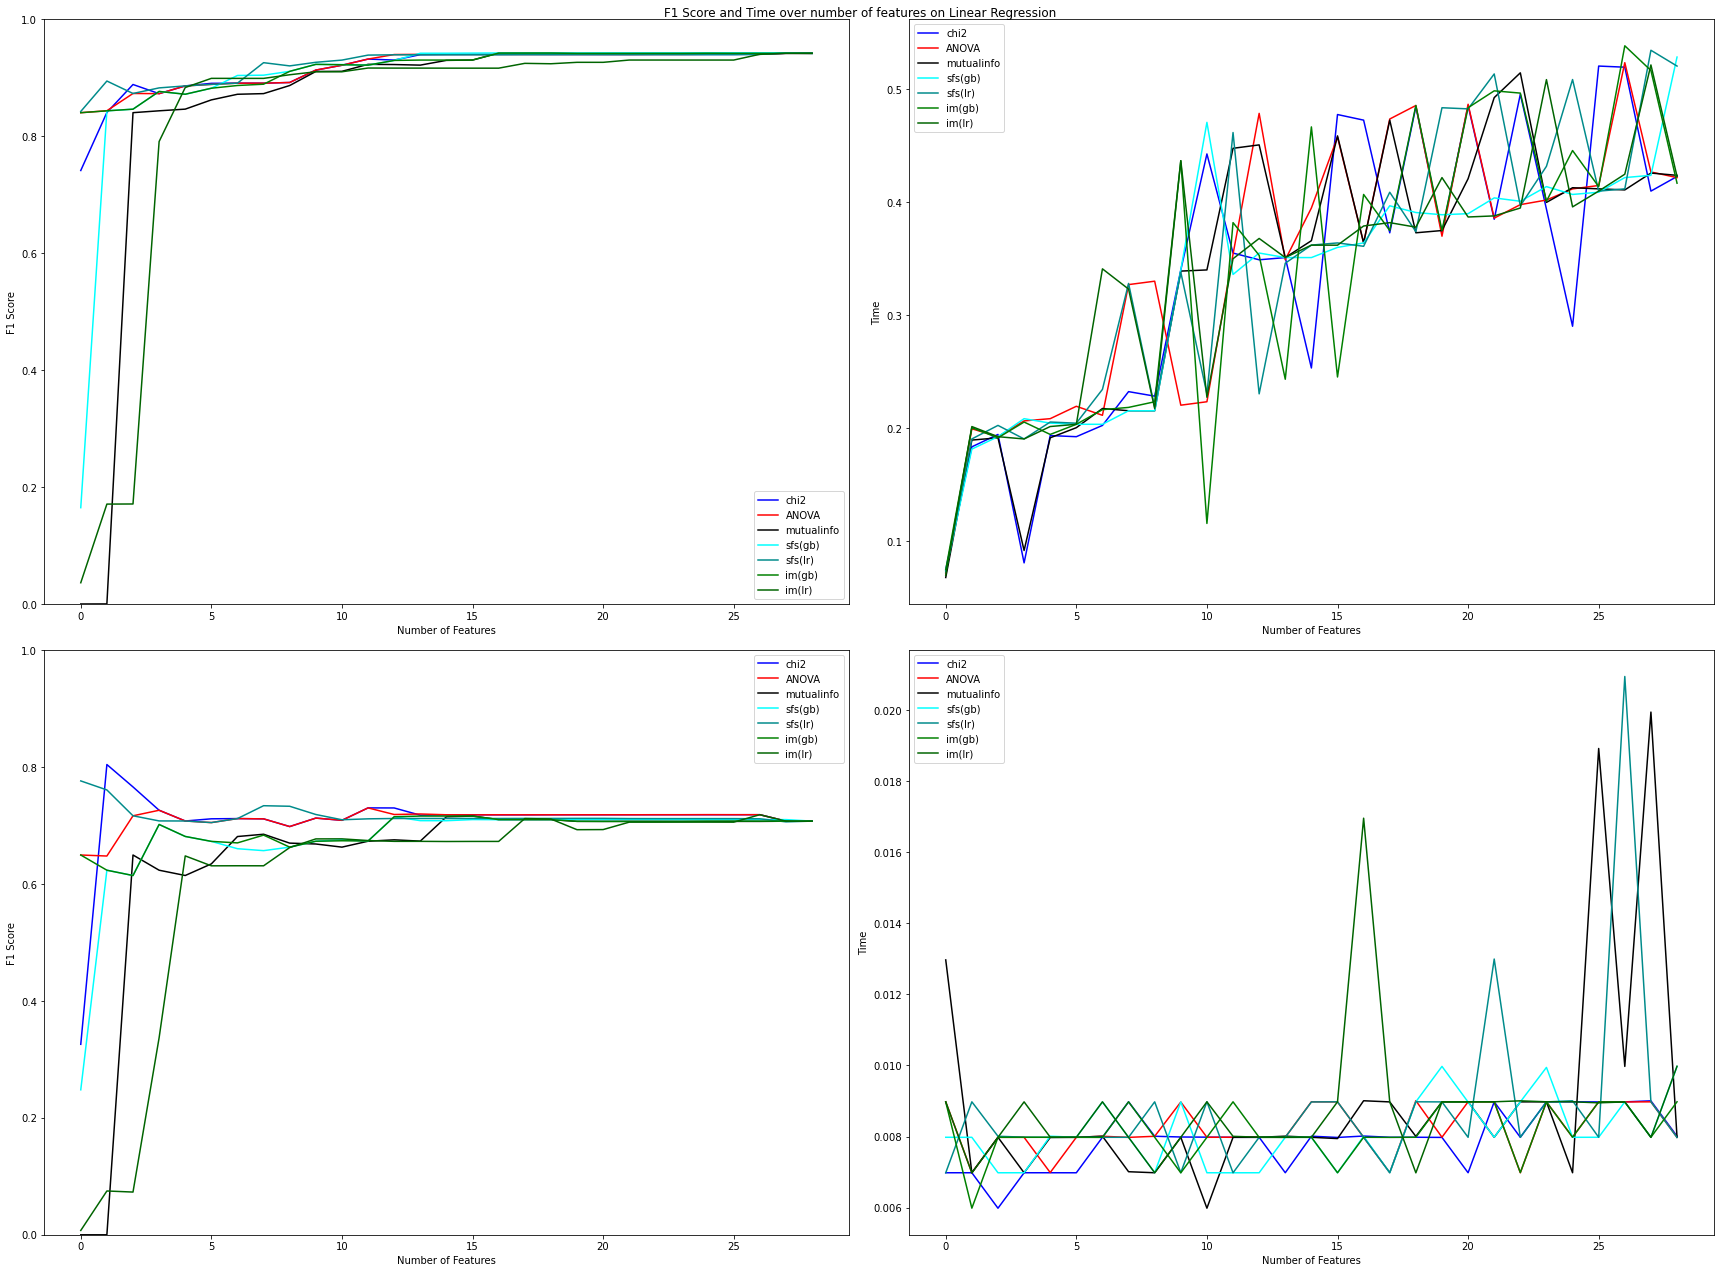

In [13]:
fig, axis = plt.subplots(2, 2, figsize=(24, 18))

plt.suptitle('F1 Score and Time over number of features on Linear Regression')
plt.subplot(2, 2, 1)
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.ylim((0, 1))

for i in range(len(methods)):
    plt.plot(range(n_of_features), np.array(cv_f1_all_LR)[i,:,0], color=colors[i], linestyle='-', label=methods[i])

plt.legend()

plt.subplot(2, 2, 2)
plt.xlabel('Number of Features')
plt.ylabel('Time')

for i in range(len(methods)):
    plt.plot(range(n_of_features), cv_time_all_LR[i], color=colors[i], linestyle='-', label=methods[i])

plt.legend()

plt.subplot(2, 2, 3)
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.ylim((0, 1))

for i in range(len(methods)):
    plt.plot(range(n_of_features), np.array(test_f1_all_LR)[i,:], color=colors[i], linestyle='-', label=methods[i])

plt.legend()

plt.subplot(2, 2, 4)
plt.xlabel('Number of Features')
plt.ylabel('Time')

for i in range(len(methods)):
    plt.plot(range(n_of_features), test_time_all_LR[i], color=colors[i], linestyle='-', label=methods[i])

plt.legend()

plt.tight_layout()
plt.show()

## Gradient Boosting Decision Tree

In [14]:
# measure performance by cv(f1 score) and test(f1 score)
cv_time_all_GB = []
cv_f1_all_GB = []
test_time_all_GB = []
test_f1_all_GB = []
model = GradientBoostingClassifier(n_estimators=200, random_state=0)
for i in range(len(subset_all)):
    cv_time = []
    cv_f1 = []
    test_time = []
    test_f1 = []
    for k in trange(n_of_features):
        # cross validation
        second = time.time()
        cv = cross_val_score(model, train_X1[subset_all[i][:k+1]], train_Y, scoring='f1', cv=kf, n_jobs=-1)
        second2 = time.time()
        cv_time.append(second2 - second)
        cv_f1.append((cv.mean(), cv.std()))

        model.fit(train_X1[subset_all[i][:k+1]], train_Y)
        second = time.time()
        predict = model.predict(test_X1[subset_all[i][:k+1]])
        score = f1_score(test_Y, predict)
        second2 = time.time()
        test_time.append(second2 - second)
        test_f1.append(score)
    
    cv_time_all_GB.append(cv_time)
    cv_f1_all_GB.append(cv_f1)
    test_time_all_GB.append(test_time)
    test_f1_all_GB.append(test_f1)

100%|██████████| 29/29 [14:45<00:00, 30.53s/it]


In [15]:
pd.DataFrame(cv_time_all_GB, index=methods).to_csv('../Results/' + dataset_name + '/Individual_CV_Time_GB.csv')
pd.DataFrame(cv_f1_all_GB, index=methods).to_csv('../Results/' + dataset_name + '/Individual_CV_F1_GB.csv')
pd.DataFrame(test_time_all_GB, index=methods).to_csv('../Results/' + dataset_name + '/Individual_Test_Time_GB.csv')
pd.DataFrame(test_f1_all_GB, index=methods).to_csv('../Results/' + dataset_name + '/Individual_Test_F1_GB.csv')

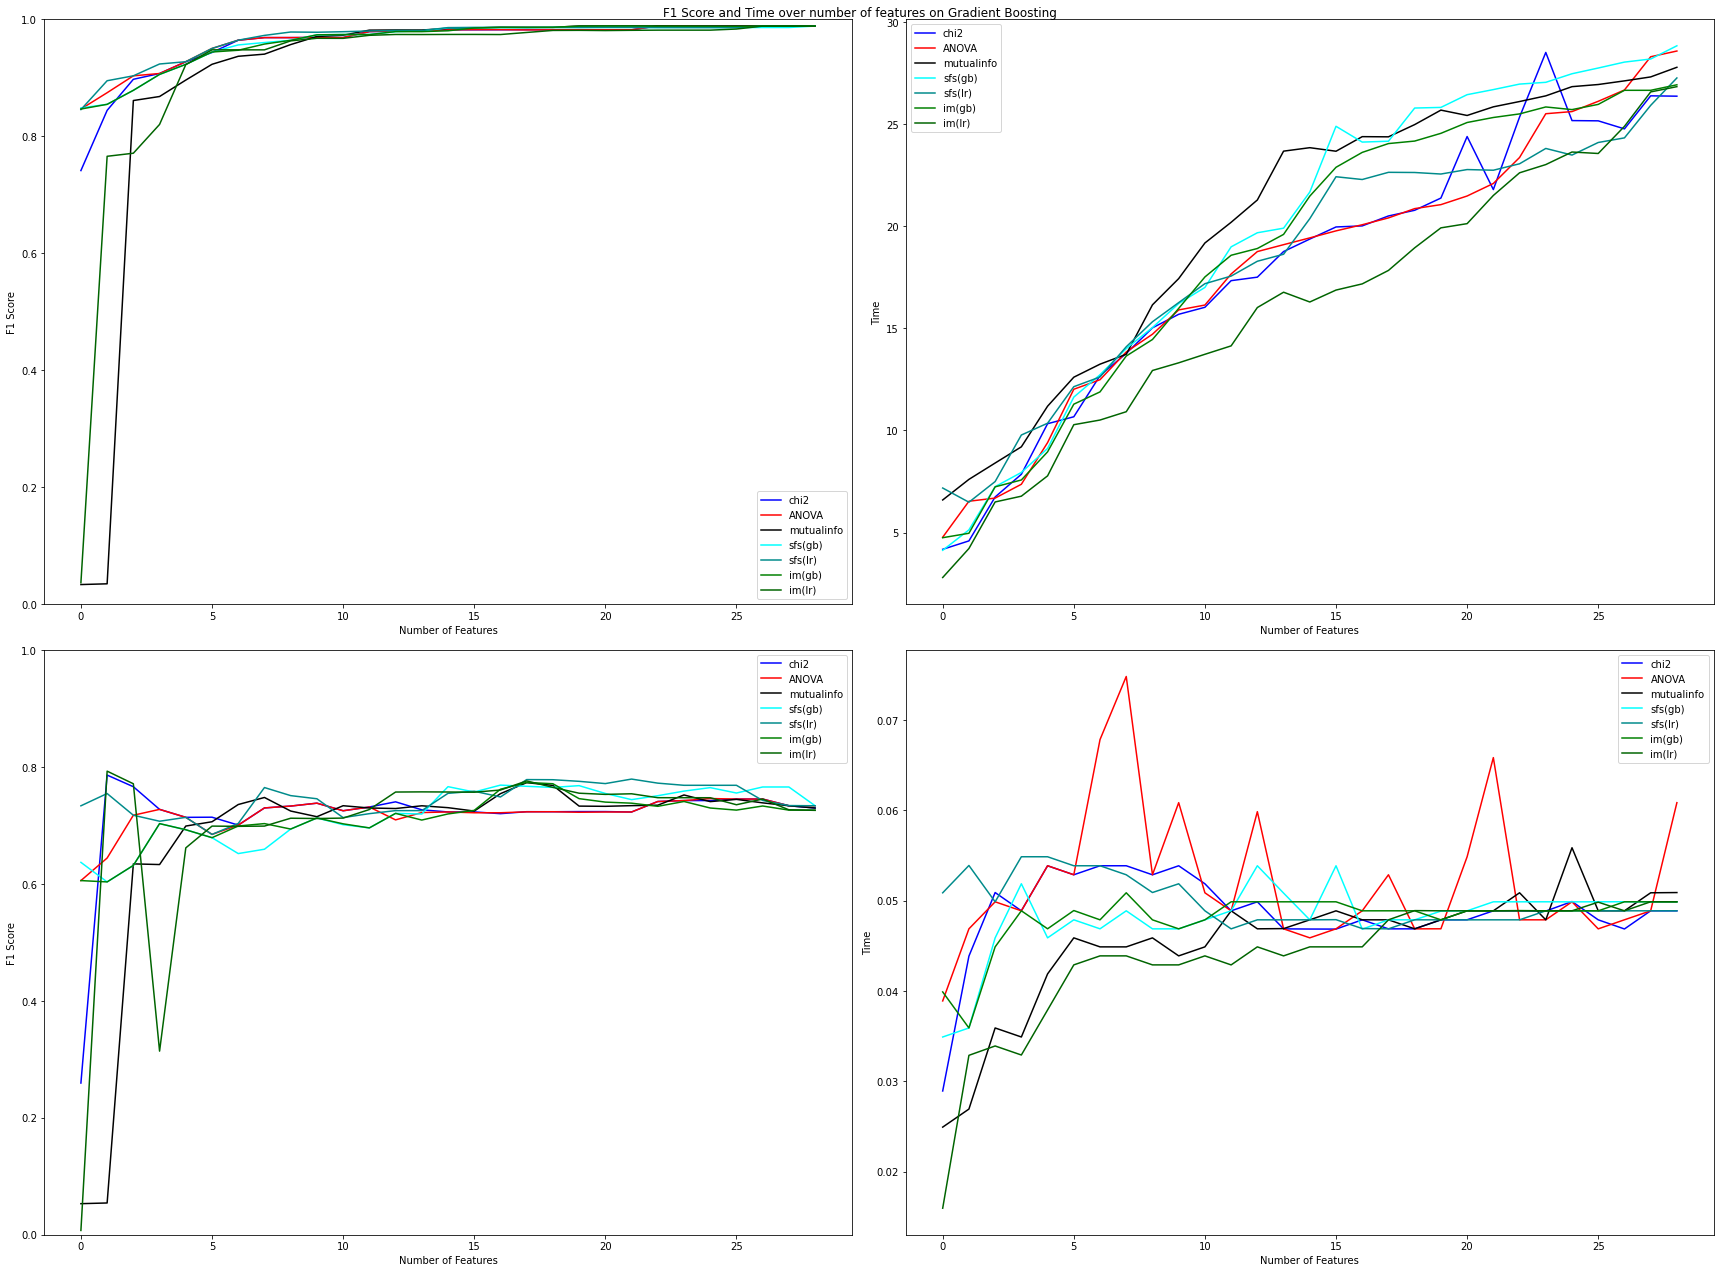

In [16]:
fig, axis = plt.subplots(2, 2, figsize=(24, 18))

plt.suptitle('F1 Score and Time over number of features on Gradient Boosting')
plt.subplot(2, 2, 1)
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.ylim((0, 1))

for i in range(len(methods)):
    plt.plot(range(n_of_features), np.array(cv_f1_all_GB)[i,:,0], color=colors[i], linestyle='-', label=methods[i])

plt.legend()

plt.subplot(2, 2, 2)
plt.xlabel('Number of Features')
plt.ylabel('Time')

for i in range(len(methods)):
    plt.plot(range(n_of_features), cv_time_all_GB[i], color=colors[i], linestyle='-', label=methods[i])

plt.legend()

plt.subplot(2, 2, 3)
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.ylim((0, 1))

for i in range(len(methods)):
    plt.plot(range(n_of_features), np.array(test_f1_all_GB)[i,:], color=colors[i], linestyle='-', label=methods[i])

plt.legend()

plt.subplot(2, 2, 4)
plt.xlabel('Number of Features')
plt.ylabel('Time')

for i in range(len(methods)):
    plt.plot(range(n_of_features), test_time_all_GB[i], color=colors[i], linestyle='-', label=methods[i])

plt.legend()

plt.tight_layout()
plt.show()

## Neuron Network

In [17]:
import tensorflow as tf
from tensorflow.keras import Sequential, layers, optimizers, losses, metrics, callbacks

In [18]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [19]:
n_epoch = 15
batch_size = 100

In [20]:
def ModelCreate(input_shape):
    model = Sequential()
    model.add(layers.Dense(50, activation='relu', input_shape=input_shape))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(50, activation='relu', input_shape=input_shape))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(50, activation='relu', input_shape=input_shape))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(50, activation='relu', input_shape=input_shape))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizers.Adam(), loss=losses.binary_crossentropy, metrics=[metrics.binary_accuracy])
    return model

In [21]:
cv_time_all_NN = []
cv_f1_all_NN = []
test_time_all_NN = []
test_f1_all_NN = []

for i in range(len(subset_all)):
    cv_time = []
    cv_f1 = []
    test_time = []
    test_f1 = []
    for k in trange(n_of_features):
        model = ModelCreate((k+1,))
        # cross validation
        j = 0
        cv_time_ = 0
        cv = np.zeros(shape=5)
        train_X2 = train_X1[subset_all[i][:k+1]].copy()
        for train_index, validation_index in kf.split(train_X2, train_Y):
            x_train_fold, x_validation_fold = train_X2.iloc[train_index, :], train_X2.iloc[validation_index, :]
            y_train_fold, y_validation_fold = train_Y.iloc[train_index], train_Y.iloc[validation_index]

            second = time.time()
            model.fit(x_train_fold.values, y_train_fold.values,
                epochs=n_epoch, batch_size=batch_size,
                use_multiprocessing=True, verbose=0)
            predict = model.predict(x_validation_fold, use_multiprocessing=True)
            predict = np.where(predict < 0.5, 0, 1)
            cv[j] = f1_score(y_validation_fold, predict)
            second2 = time.time()
            cv_time_ += second2 - second
            j += 1
        cv_time.append(cv_time_)
        cv_f1.append((cv.mean(), cv.std()))

        second = time.time()
        model.fit(train_X1[subset_all[i][:k+1]].values, train_Y.values,
                epochs=n_epoch, batch_size=batch_size,
                use_multiprocessing=True, verbose=0)
        predict = model.predict(test_X1[subset_all[i][:k+1]], use_multiprocessing=True)
        predict = np.where(predict < 0.5, 0, 1)
        score = f1_score(test_Y, predict)
        second2 = time.time()
        test_time.append(second2-second)
        test_f1.append(score)
    
    cv_time_all_NN.append(cv_time)
    cv_f1_all_NN.append(cv_f1)
    test_time_all_NN.append(test_time)
    test_f1_all_NN.append(test_f1)

100%|██████████| 29/29 [3:02:21<00:00, 377.29s/it]  


In [22]:
pd.DataFrame(cv_time_all_NN, index=methods).to_csv('../Results/' + dataset_name + '/Individual_CV_Time_NN.csv')
pd.DataFrame(cv_f1_all_NN, index=methods).to_csv('../Results/' + dataset_name + '/Individual_CV_F1_NN.csv')
pd.DataFrame(test_time_all_NN, index=methods).to_csv('../Results/' + dataset_name + '/Individual_Test_Time_NN.csv')
pd.DataFrame(test_f1_all_NN, index=methods).to_csv('../Results/' + dataset_name + '/Individual_Test_F1_NN.csv')

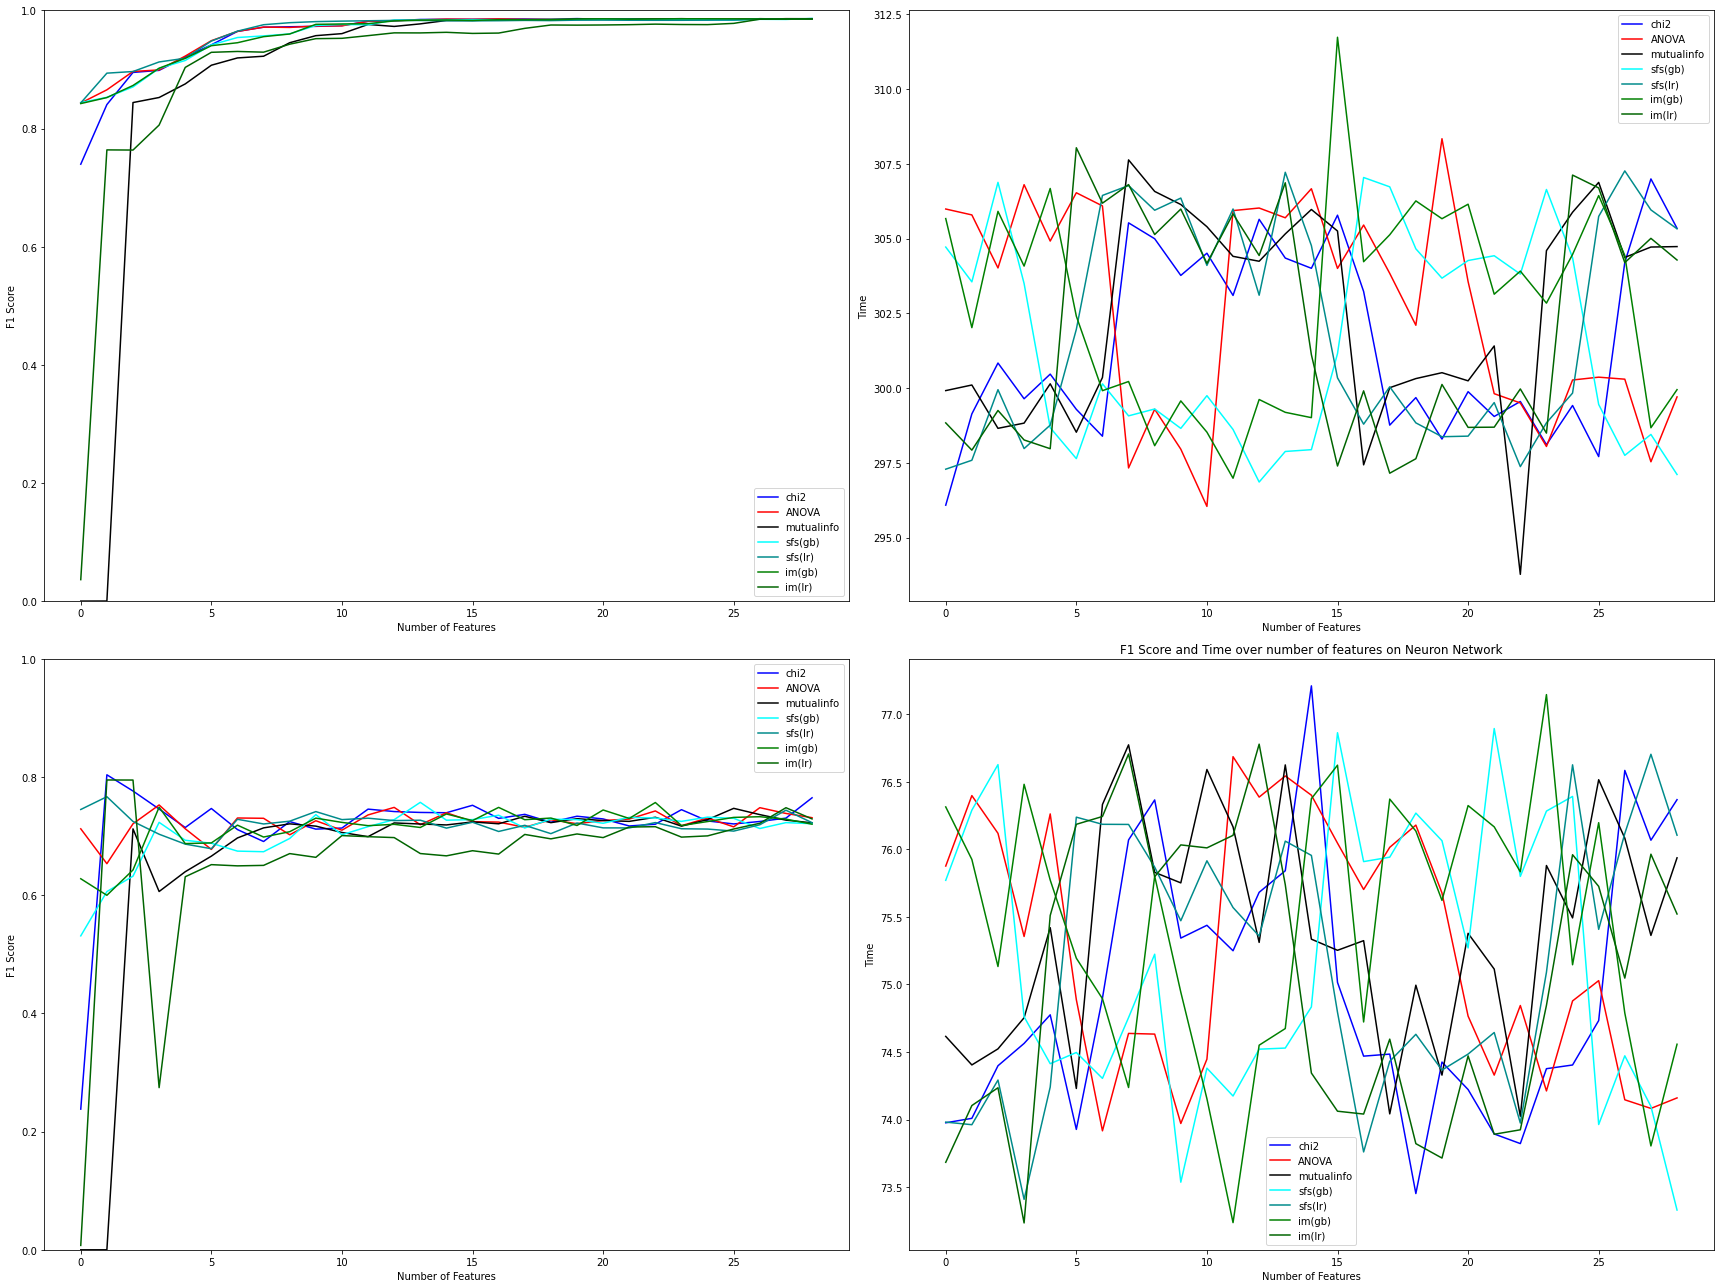

In [23]:
fig, axis = plt.subplots(2, 2, figsize=(24, 18))

plt.title('F1 Score and Time over number of features on Neuron Network', loc='center')
plt.subplot(2, 2, 1)
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.ylim((0, 1))

for i in range(len(methods)):
    plt.plot(range(n_of_features), np.array(cv_f1_all_NN)[i,:,0], color=colors[i], linestyle='-', label=methods[i])

plt.legend()

plt.subplot(2, 2, 2)
plt.xlabel('Number of Features')
plt.ylabel('Time')

for i in range(len(methods)):
    plt.plot(range(n_of_features), cv_time_all_NN[i], color=colors[i], linestyle='-', label=methods[i])

plt.legend()

plt.subplot(2, 2, 3)
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.ylim((0, 1))

for i in range(len(methods)):
    plt.plot(range(n_of_features), np.array(test_f1_all_NN)[i,:], color=colors[i], linestyle='-', label=methods[i])

plt.legend()

plt.subplot(2, 2, 4)
plt.xlabel('Number of Features')
plt.ylabel('Time')

for i in range(len(methods)):
    plt.plot(range(n_of_features), test_time_all_NN[i], color=colors[i], linestyle='-', label=methods[i])

plt.legend()

plt.tight_layout()
plt.show()